In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [19]:
import numpy as np
from pyDOE import lhs
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

In [21]:
L = 4
E = 210e9
def deformation_function(b_array, h_array, w_array):
    I_array = (b_array*h_array**3) / 12
    beam_deformation = (w_array*L**3)/(48*E*I_array)
    return beam_deformation

variable_range = {
    'b': (0.2, 1),
    'h': (0.2, 1),
    'w':(15e4, 100e5)
}
np.random.seed(42)
n_initial_sample = 200
n_variables = len(variable_range)
lhs_samples = lhs(n_variables,
                 samples = n_initial_sample,
                 criterion = 'maximin')

x_initial = np.zeros_like(lhs_samples)
for i, (key, (min_val, max_val)) in enumerate(variable_range.items()):
    x_initial[:, i] = min_val + lhs_samples[:, i] * (max_val - min_val)

b_array = x_initial[:, 0]
h_array = x_initial[:, 1]
w_array = x_initial[:, 2]
y_initial = deformation_function(b_array, h_array, w_array)

In [28]:
x_scaler = StandardScaler()
x_initial_scaled = x_scaler.fit_transform(x_initial)

pipeline = Pipeline([
    ('svr', SVR())
])

param_space = {
    'svr__C': Real(1e-3, 1e3),
    'svr__epsilon': Real(1e-4, 1e1),
    'svr__gamma': Real(1e-4, 1e0),
    'svr__kernel': Categorical(['linear', 'poly', 'rbf', 'sigmoid']),
    'svr__degree': Integer(2, 5)
}

cv = KFold(n_splits=5,
          shuffle=True,
          random_state=42)

bayes_search = BayesSearchCV(
    estimator=pipeline,
    search_spaces=param_space,
    scoring='neg_mean_squared_error',
    n_iter=100,
    cv=cv,
    n_jobs=-1,
    random_state=42
)

bayes_search.fit(x_initial_scaled, y_initial)
print('Best hyperparameters:', bayes_search.best_params_)
best_svr_model = bayes_search.best_estimator_

Best hyperparameters: OrderedDict({'svr__C': 410.104548749355, 'svr__degree': 4, 'svr__epsilon': 9.328686701678453, 'svr__gamma': 0.3158680135277, 'svr__kernel': 'rbf'})


In [45]:
n_iterations = 100
n_new_samples = 100
x_total = x_initial
y_total = y_initial

for iteration in range(n_iterations):

    n_candidate = 10000
    candidates_samples = np.random.rand(n_candidate, n_variables)
    x_candidates = np.zeros_like(candidates_samples)
    for i, (key, (min_val, max_val)) in enumerate(variable_range.items()):
        x_candidates[:, i] = min_val + (max_val - min_val)*candidates_samples[:, i]

    x_candidates_scaled = x_scaler.transform(x_candidates)
    y_pred = best_svr_model.predict(x_candidates_scaled)
    y_mean_values = np.mean(y_pred)
    uncertainty = np.abs(y_pred - y_mean_values)
    indices = np.argsort(-uncertainty)[:n_new_samples]

    x_new_samples = x_candidates[indices]
    b_array = x_new_samples[:, 0]
    h_array = x_new_samples[:, 1]
    w_array = x_new_samples[:, 2]
    y_new_samples = deformation_function(b_array, h_array, w_array)
    
    x_total = np.vstack((x_total, x_new_samples))
    y_total = np.concatenate((y_total, y_new_samples))
    
    x_scaler.fit(x_total)
    x_total_scaled = x_scaler.transform(x_total)
    best_svr_model.fit(x_total_scaled, y_total)
    print(f'Iteration {iteration + 1}/{n_iterations} completed')

n_validation_sample = 50
lhs_validation = lhs(n_variables,
                    samples=n_validation_sample,
                    criterion='maximin')

x_validation = np.zeros_like(lhs_validation)
for i, (key, (min_val, max_val)) in enumerate(variable_range.items()):
    x_validation[:, i] = min_val + (max_val - min_val)*lhs_validation[:, i]

b_array = x_validation[:, 0]
h_array = x_validation[:, 1]
w_array = x_validation[:, 2]
y_validation = deformation_function(b_array, h_array, w_array)

x_validation_scaled = x_scaler.transform(x_validation)
y_pred_validation = best_svr_model.predict(x_validation_scaled)

MSE = mean_squared_error(y_validation, y_pred_validation)
r2_score_val = r2_score(y_validation, y_pred_validation)
print(f'MSE: {MSE:.4e}')
print(f"Validation R^2 Score: {r2_score_val:.4f}")

Iteration 1/100 completed
Iteration 2/100 completed
Iteration 3/100 completed
Iteration 4/100 completed
Iteration 5/100 completed
Iteration 6/100 completed
Iteration 7/100 completed
Iteration 8/100 completed
Iteration 9/100 completed
Iteration 10/100 completed
Iteration 11/100 completed
Iteration 12/100 completed
Iteration 13/100 completed
Iteration 14/100 completed
Iteration 15/100 completed
Iteration 16/100 completed
Iteration 17/100 completed
Iteration 18/100 completed
Iteration 19/100 completed
Iteration 20/100 completed
Iteration 21/100 completed
Iteration 22/100 completed
Iteration 23/100 completed
Iteration 24/100 completed
Iteration 25/100 completed
Iteration 26/100 completed
Iteration 27/100 completed
Iteration 28/100 completed
Iteration 29/100 completed
Iteration 30/100 completed
Iteration 31/100 completed
Iteration 32/100 completed
Iteration 33/100 completed
Iteration 34/100 completed
Iteration 35/100 completed
Iteration 36/100 completed
Iteration 37/100 completed
Iteration 

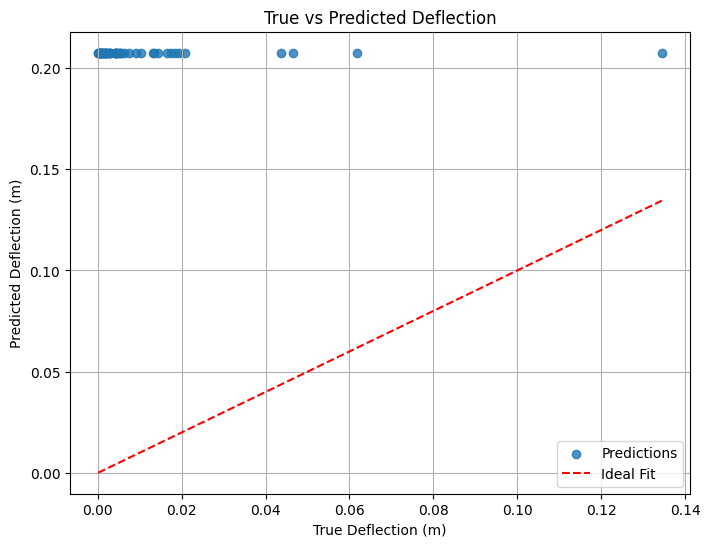

In [43]:
plt.figure(figsize=(8, 6))
plt.scatter(y_validation, 
            y_pred_validation,
            alpha=.8, 
            label='Predictions')
plt.plot([y_validation.min(), y_validation.max()], [y_validation.min(), y_validation.max()], 'r--', label='Ideal Fit')
plt.xlabel('True Deflection (m)')
plt.ylabel('Predicted Deflection (m)')
plt.title('True vs Predicted Deflection')
plt.legend()
plt.grid(True)
plt.show()

### Importance of using seeds
**Reproducibility** is one of the cornerstone of scientific research and computational experiments. So, following are the reasons why seeds are vital:
* **Verification**: Allows replication of the exact sampling process and verify results.
* **Consistency in optimization**: In optimization tasks, especially those involving stochastic algorithms, consistent initial samples can lead to consistent optimization results.
* **Comparative studies**: Enable fair comparison between different methods or algorithms by using the set of sampling points.

**Note** - without seed every execution might produce a different set of samples, making it challenging to reproduce consistent results.

In [64]:
# lhs_sampler = qmc.LatinHypercube(d=4,
#                                  seed=42)

# lower_bounds =
# upper_bounds =

# num_samples_initial = 100
# lhs_sample_unit = lhs_sampler.random(n=num_samples_initial)

# scaled_samples = qmc.scale(lhs_sample_unit,
#                           lower_bounds,
#                           upper_bounds)

# lhs_samples_data_frame = pd.DataFrame(scaled_samples, 
#                                       columns=['P(Load)',
#                                                'L(Length)',
#                                                'h(height)',
#                                                'b(width)'
#                                                ])

# num_bins = sqrt(num_samples_initial)

# plt.hist(lhs_samples_data_frame.iloc[:,0], 
#          bins=int(num_bins),
#          edgecolor='black')
# plt.title('Histogram for $P(Load)$', fontweight='bold')
# plt.xlabel('Applied Load Range')
# plt.ylabel('Frequency')
# plt.grid(False)
# plt.show()

SyntaxError: invalid syntax (1509672872.py, line 4)

In [48]:
P_array = np.array(lhs_samples_data_frame.iloc[:, 0])
L_array = np.array(lhs_samples_data_frame.iloc[:, 1])
h_array = np.array(lhs_samples_data_frame.iloc[:, 2])
b_array = np.array(lhs_samples_data_frame.iloc[:, 3])
E = 210e9

def deformation_function(b_array, h_array, P_array, L_array):
    I_array = (b_array*h_array**3)/12
    beam_deformation = (P_array*L_array**3)/(48*E*I_array)
    return beam_deformation

In [49]:
x_beam_sample_vector = np.column_stack((P_array, L_array, h_array, b_array))
y_deformation_vector_initial = deformation_function(P_array, L_array, h_array, b_array)

In [50]:
# x_train, x_test, y_train, y_test = train_test_split(x_beam_sample_vector,
#                                                    y_deformation_vector,
#                                                    test_size = 0.2,
#                                                    random_state = 42)

In [51]:
scaler_vector = StandardScaler()
x_scaled_initial = scaler_vector.fit_transform(x_beam_sample_vector)

In [52]:
tuning_parameters = {
    'C' : [1000],
    'epsilon' : [.0001],
    'gamma' : ['scale'],
    'kernel' : ['rbf']
}

In [53]:
svr_model = SVR(kernel='rbf', C=1e3, gamma='scale', epsilon=1e-4)
svr_model.fit(x_scaled_initial, 
             y_deformation_vector_initial)

SVR(C=1000.0, epsilon=0.0001)

In [100]:
svr = SVR()
grid_search = GridSearchCV(
    estimator=svr,
    param_grid = tuning_parameters,
    cv = 5,
    n_jobs=-1,
    scoring = 'neg_mean_squared_error'
)
grid_search.fit(x_train_scaled, y_train)
print("Best parameters:", grid_search.best_params_)

Best parameters: {'C': 100, 'epsilon': 0.001, 'gamma': 'auto', 'kernel': 'rbf'}


In [101]:
best_svr = grid_search.best_estimator_
y_prediction = best_svr.predict(x_test_scaled)
MSE = mean_squared_error(y_test, y_prediction)
r2 = r2_score(y_test, y_prediction)

print('MSE:', MSE)
print('R2 Scores', r2)

MSE: 2.7842434726302498e-05
R2 Scores 0.9760305875260356


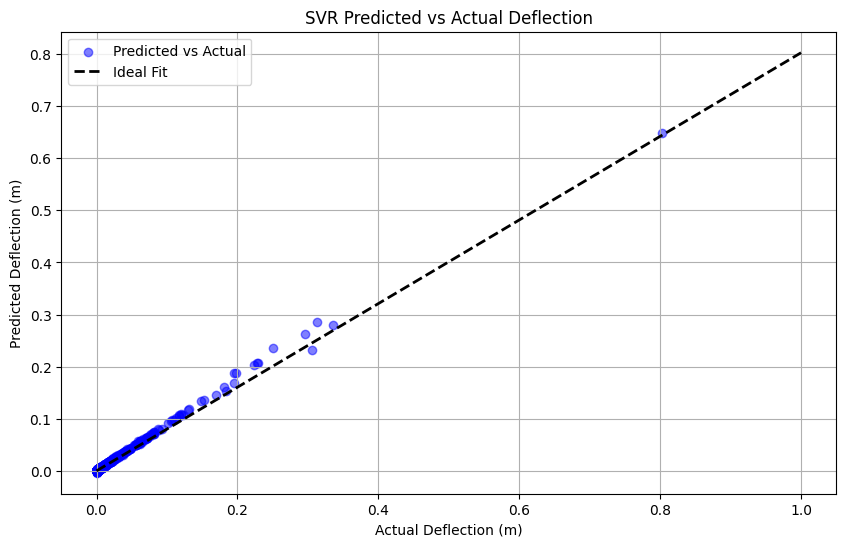

In [102]:
plt.figure(figsize=(10, 6))                           
plt.scatter(y_test, y_prediction, alpha=0.5, color='blue', label='Predicted vs Actual') 
plt.plot([y_test.min(), y_test.max()], 'k--', lw=2, label='Ideal Fit')  
plt.xlabel('Actual Deflection (m)')                   
plt.ylabel('Predicted Deflection (m)')            
plt.title('SVR Predicted vs Actual Deflection')      
plt.legend()                                          
plt.grid(True)                                       
plt.show()  